# Transfer Learning

## Import packages

In [38]:
import datetime
import tensorflow as tf
from tensorflow.keras import Sequential, models, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import cv2

physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) >= 1:
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.1 Load the CIFAR10 dataset and build cnn model

In [2]:
model = Sequential(name="cifar10")
model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [3]:
model.summary()

Model: "cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1849

In [4]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [5]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [6]:

# initial cifar image shape
print(tf.shape(train_images))
print(tf.shape(test_images))
print(tf.shape(train_labels))
print(tf.shape(test_labels))

tf.Tensor([50000    32    32     3], shape=(4,), dtype=int32)
tf.Tensor([10000    32    32     3], shape=(4,), dtype=int32)
tf.Tensor([50000     1], shape=(2,), dtype=int32)
tf.Tensor([10000     1], shape=(2,), dtype=int32)


In [7]:
# initial cifar image shape
print(tf.shape(train_labels))

tf.Tensor([50000     1], shape=(2,), dtype=int32)


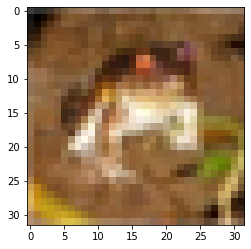

In [8]:
plt.imshow(train_images[0])

In [9]:
x_train = train_images / 255
x_test = test_images / 255

NUM_CLASSES = 10

y_train = to_categorical(train_labels, NUM_CLASSES)
y_test = to_categorical(test_labels, NUM_CLASSES)

In [10]:


print(tf.shape(x_train))
print(tf.shape(y_train))

tf.Tensor([50000    32    32     3], shape=(4,), dtype=int32)
tf.Tensor([50000    10], shape=(2,), dtype=int32)


## 1.2 Train this CNN for 10 epochs or more using a batch size of 32

In [11]:

epochs = 15
batch_size = 32

with tf.device('/device:GPU:0'):
    model.fit(x_train,
              y_train,
              validation_data=(x_test, y_test),
              epochs=epochs,
              batch_size=batch_size)

Epoch 1/15
1563/1563 [==============================] - 5s 3ms/step - loss: 1.4898 - accuracy: 0.4596 - val_loss: 1.1515 - val_accuracy: 0.5889
Epoch 2/15
1563/1563 [==============================] - 5s 3ms/step - loss: 1.0841 - accuracy: 0.6179 - val_loss: 0.9084 - val_accuracy: 0.6817
Epoch 3/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9312 - accuracy: 0.6738 - val_loss: 0.8312 - val_accuracy: 0.7117
Epoch 4/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8438 - accuracy: 0.7055 - val_loss: 0.8135 - val_accuracy: 0.7184
Epoch 5/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7742 - accuracy: 0.7315 - val_loss: 0.7141 - val_accuracy: 0.7525
Epoch 6/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7311 - accuracy: 0.7436 - val_loss: 0.7340 - val_accuracy: 0.7467
Epoch 7/15
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6939 - accuracy: 0.7579 - val_loss: 0.7006 - val_accuracy:

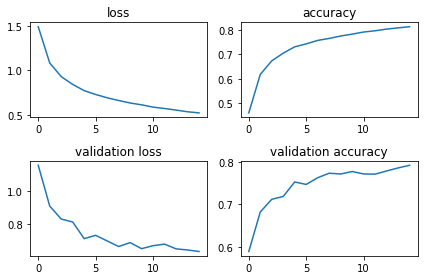

In [12]:

history = model.history.history

fig = plt.figure()

loss = fig.add_subplot(221)
loss.set_title('loss')
loss.plot(history['loss'])

accuracy = fig.add_subplot(222)
accuracy.set_title('accuracy')
accuracy.plot(history['accuracy'])

val_loss = fig.add_subplot(223)
val_loss.set_title('validation loss')
val_loss.plot(history['val_loss'])

val_accuracy = fig.add_subplot(224)
val_accuracy.set_title('validation accuracy')
val_accuracy.plot(history['val_accuracy'])

plt.tight_layout()
plt.show(fig)

In [13]:
model.save('train_cifar10.h5')

## 1.3 Analyze model performance

In [14]:
y_act = tf.reshape(test_labels, [len(test_labels)])
print(y_act[:2])

tf.Tensor([3 8], shape=(2,), dtype=uint8)


In [15]:
preds = model.predict(x_test)
y_pred = tf.math.argmax(preds, 1)
print(y_pred[:2])

tf.Tensor([3 8], shape=(2,), dtype=int64)


In [16]:
classification_report = metrics.classification_report(y_act, y_pred)
print(classification_report)

precision    recall  f1-score   support

           0       0.80      0.84      0.82      1000
           1       0.90      0.89      0.89      1000
           2       0.76      0.64      0.70      1000
           3       0.66      0.56      0.60      1000
           4       0.69      0.83      0.76      1000
           5       0.68      0.74      0.71      1000
           6       0.79      0.88      0.83      1000
           7       0.87      0.84      0.85      1000
           8       0.92      0.84      0.88      1000
           9       0.86      0.87      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [17]:
labels = [0,1,2,3,4,5,6,7,8,9]
confusion_matrix = metrics.confusion_matrix(y_act, y_pred, labels=labels, normalize=None)
print(confusion_matrix)

[[844  15  28  14  19   5  14   7  28  26]
 [  9 888   4   7   2   5   9   1  14  61]
 [ 61   2 641  44  95  65  60  21   8   3]
 [ 17   4  43 555  90 179  72  27   3  10]
 [ 13   0  40  30 827  19  33  32   4   2]
 [  7   1  31 116  47 737  25  30   3   3]
 [  7   2  22  31  39  17 876   3   2   1]
 [  8   0  19  34  49  43   6 836   2   3]
 [ 65  24  10   9  12   2   4   2 845  27]
 [ 21  55   5   6  10   5  10   7  13 868]]


## 1.4 Import VGG16 from keras without the top layer

In [11]:
# code snippets taken from Deep Learning for Vision Systems MEAP V08 livebook by Mohamed Elgendy

# download the model’s pretrained weights and save it in the variable base_model
# note that here we specified to keras to download the imagenet weights
# include_top is false to ignore the FC classifier part on top of the model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

## 1.5 Freeze all layers in the pretrained VGG16 model

In [12]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

## 1.6 Add classification layers to the top of the model

In [13]:
# https://www.tensorflow.org/guide/keras/transfer_learning

# use “get_layer” method to save the last layer of the network
last_layer = base_model.get_layer('block3_pool').output

x = GlobalAveragePooling2D()(last_layer)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(10, activation='softmax')(x)

# instantiate a new_model using keras’s Model class
vgg_model = Model(base_model.input, outputs, name="vgg_cifar10")
 
# print the new_model summary
vgg_model.summary()

Model: "vgg_cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       

In [14]:
vgg_model.compile(optimizer=tf.optimizers.Adam(lr=0.00075),
                  loss=CategoricalCrossentropy(label_smoothing=0.2), 
                  metrics=['accuracy'])

## 1.8 Use the keras data generator function to load in cifar10 image data

In [15]:
# https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py

x_train_vgg = np.array([cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_CUBIC) for img in train_images])
x_test_vgg = np.array([cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_CUBIC) for img in test_images])

data_gen_train = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

data_gen_test = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

data_gen_train.fit(x_train_vgg)
data_gen_test.fit(x_test_vgg)

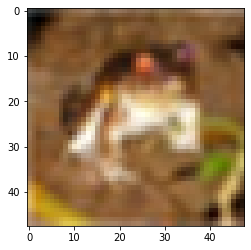

In [16]:
plt.imshow(x_train_vgg[0])

## 1.9 Train pre-trained CNN for 10 epochs

In [17]:
epochs = 25
batch_size = 128

train_generator = data_gen_train.flow(x_train_vgg, y_train, batch_size=batch_size)
test_generator = data_gen_test.flow(x_test_vgg, y_test, batch_size=batch_size)

epoch_steps_train = len(x_train_vgg) // batch_size
epoch_steps_test = len(x_test_vgg) // batch_size

with tf.device('/device:GPU:0'):
    vgg_model.fit(train_generator,
                steps_per_epoch=epoch_steps_train,
                validation_data=test_generator,
                validation_steps=epoch_steps_test,
                epochs=epochs)

Epoch 1/25
390/390 [==============================] - 24s 61ms/step - loss: 1.7115 - accuracy: 0.5472 - val_loss: 1.5158 - val_accuracy: 0.6548
Epoch 2/25
390/390 [==============================] - 24s 60ms/step - loss: 1.5415 - accuracy: 0.6507 - val_loss: 1.4618 - val_accuracy: 0.6888
Epoch 3/25
390/390 [==============================] - 24s 61ms/step - loss: 1.4939 - accuracy: 0.6790 - val_loss: 1.4368 - val_accuracy: 0.7044
Epoch 4/25
390/390 [==============================] - 24s 61ms/step - loss: 1.4685 - accuracy: 0.6925 - val_loss: 1.4131 - val_accuracy: 0.7170
Epoch 5/25
390/390 [==============================] - 24s 60ms/step - loss: 1.4464 - accuracy: 0.7066 - val_loss: 1.4028 - val_accuracy: 0.7258
Epoch 6/25
390/390 [==============================] - 24s 61ms/step - loss: 1.4317 - accuracy: 0.7135 - val_loss: 1.3898 - val_accuracy: 0.7293
Epoch 7/25
390/390 [==============================] - 24s 61ms/step - loss: 1.4201 - accuracy: 0.7208 - val_loss: 1.3835 - val_accuracy:

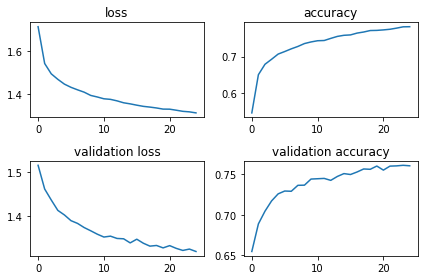

In [18]:
vgg_model_history = vgg_model.history.history

vgg_model_fig = plt.figure()

loss = vgg_model_fig.add_subplot(221)
loss.set_title('loss')
loss.plot(vgg_model_history['loss'])

accuracy = vgg_model_fig.add_subplot(222)
accuracy.set_title('accuracy')
accuracy.plot(vgg_model_history['accuracy'])

val_loss = vgg_model_fig.add_subplot(223)
val_loss.set_title('validation loss')
val_loss.plot(vgg_model_history['val_loss'])

val_accuracy = vgg_model_fig.add_subplot(224)
val_accuracy.set_title('validation accuracy')
val_accuracy.plot(vgg_model_history['val_accuracy'])

plt.tight_layout()
plt.show(vgg_model_fig)

In [19]:
vgg_preds = vgg_model.predict(x_test_vgg)
y_pred_vgg = tf.math.argmax(vgg_preds, 1)
print(y_pred_vgg[:2])

tf.Tensor([1 1], shape=(2,), dtype=int64)


In [20]:
y_act = tf.reshape(test_labels, [len(test_labels)])
classification_report = metrics.classification_report(y_act, y_pred_vgg)
print(classification_report)

precision    recall  f1-score   support

           0       0.54      0.54      0.54      1000
           1       0.28      0.93      0.43      1000
           2       0.00      0.00      0.00      1000
           3       0.20      0.68      0.31      1000
           4       0.00      0.00      0.00      1000
           5       1.00      0.00      0.00      1000
           6       0.00      0.00      0.00      1000
           7       0.71      0.31      0.43      1000
           8       0.67      0.45      0.54      1000
           9       0.48      0.57      0.52      1000

    accuracy                           0.35     10000
   macro avg       0.39      0.35      0.28     10000
weighted avg       0.39      0.35      0.28     10000



In [21]:
labels = [0,1,2,3,4,5,6,7,8,9]
confusion_matrix = metrics.confusion_matrix(y_act, y_pred_vgg, labels=labels, normalize=None)
print(confusion_matrix)

[[538 326   0  51   0   0   0   6  48  31]
 [  3 933   0  16   0   0   0   0   2  46]
 [150 240   0 468   0   0   0  38  48  56]
 [  6 177   0 681   0   0   0  10  48  78]
 [ 62 334   0 473   0   0   0  40  28  63]
 [ 12 204   0 649   0   1   0  29  18  87]
 [ 14 231   0 689   0   0   0   7  16  43]
 [ 32 279   0 265   0   0   0 314   4 106]
 [169 238   0  24   0   0   0   0 451 118]
 [  5 394   0  26   0   0   0   0   6 569]]


In [22]:
model.save('train_cifar10_vgg.h5')

## 2.1 Visualize VGG16 CNN layers

In [39]:
# https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

stock_vgg_model = VGG16(weights='imagenet')

stock_vgg_layers = []

for layer in stock_vgg_model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue

	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

	stock_vgg_layers.append((layer.name, filters, biases))

553467904/553467096 [==============================] - 23s 0us/step
block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)


## 2.2 Plot the first 6 convolutional filters and view each channel separately

In [40]:
(_, layer_three_filters, layer_three_biases) = stock_vgg_layers[2]
print('weights', tf.shape(layer_three_filters))
print('biases', tf.shape(layer_three_biases))

weights tf.Tensor([  3   3  64 128], shape=(4,), dtype=int32)
biases tf.Tensor([128], shape=(1,), dtype=int32)


In [41]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = layer_three_filters.min(), layer_three_filters.max()
layer_three_filters = (layer_three_filters - f_min) / (f_max - f_min)


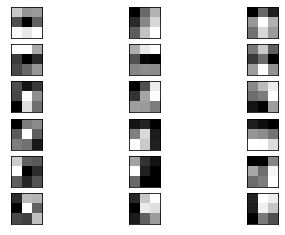

In [42]:
# plot first few filters
n_filters, ix = 6, 1

for i in range(n_filters):
	# get the filter
	f = layer_three_filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

## 2.3 Visualize the feature maps of VGG

In [53]:
vgg_model_layer_one = Model(inputs=stock_vgg_model.input, outputs=stock_vgg_model.layers[1].output)

In [54]:
feature_map_img = load_img('bird.jpg', target_size=(224, 224))
feature_map_img = img_to_array(feature_map_img)
feature_map_img = np.expand_dims(feature_map_img, axis=0)
feature_map_img = preprocess_input(feature_map_img)

In [55]:
feature_maps = vgg_model_layer_one.predict(feature_map_img)

In [56]:
vgg_model_layer_one.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## 2.4 Plot these feature maps for the outputs of 

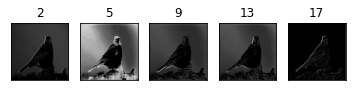

In [61]:
# plot all 64 maps in an 8x8 squares
conv_blocks = [2, 5, 9, 13, 17]

for idx, block_idx in enumerate(conv_blocks):
    # specify subplot and turn of axis
    ax = plt.subplot(1, len(conv_blocks), idx+1)
    ax.set_title(block_idx)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(feature_maps[0, :, :, block_idx], cmap='gray')

# show the figure
plt.show()